In [1]:
!CUDA_VISIBLE_DEVICES=1

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd
import random
from scipy import stats
import torch
import seaborn as sns
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from tqdm import tqdm
import celltypist

autoencoder

In [4]:
def load_VAE():
    autoencoder = VAE(
        num_genes=18996,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_scimilarity_lognorm_finetune/model_seed=0_step=150000.pt'))
    return autoencoder

real data

In [5]:
# load the real dataset
real_adata = sc.read_h5ad('../data/tabula_muris/all.h5ad')
real_adata.var_names_make_unique()
sc.pp.filter_cells(real_adata, min_genes=10)
sc.pp.filter_genes(real_adata, min_cells=3)
gene_name = real_adata.var_names

sc.pp.normalize_total(real_adata, target_sum=1e4)
sc.pp.log1p(real_adata)
real_adata

AnnData object with n_obs × n_vars = 57004 × 18996
    obs: 'celltype', 'n_genes', 'counts'
    var: 'n_cells'
    uns: 'log1p'

generated data

In [ ]:
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']

rf = []

cell_gen_all = []
gen_class = []
length_per_type = 3000

for i in range(12):
    npzfile=np.load(f'../output/muris_condi/muris_{i}_scimilarity_nodrop.npz',allow_pickle=True)
    cell_gen_all.append(npzfile['cell_gen'][:length_per_type])
    gen_class+=[cato[i]]*length_per_type
cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

sim_adata = ad.AnnData(X=cell_gen_all)
sim_adata.obs['celltype'] = gen_class

qq plot

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 47 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'H', 'K', 'L', 'M', 'Q', 'R', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'x', 'y', 'z', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 25, 27, 36, 37, 42, 43, 46, 47, 48, 52, 53, 54, 55, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93]
Closed glyph list over 'GSUB': 52 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'G', 'H', 'K', 'L', 'M', 'Q', 'R', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'fi', 'fl', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r',

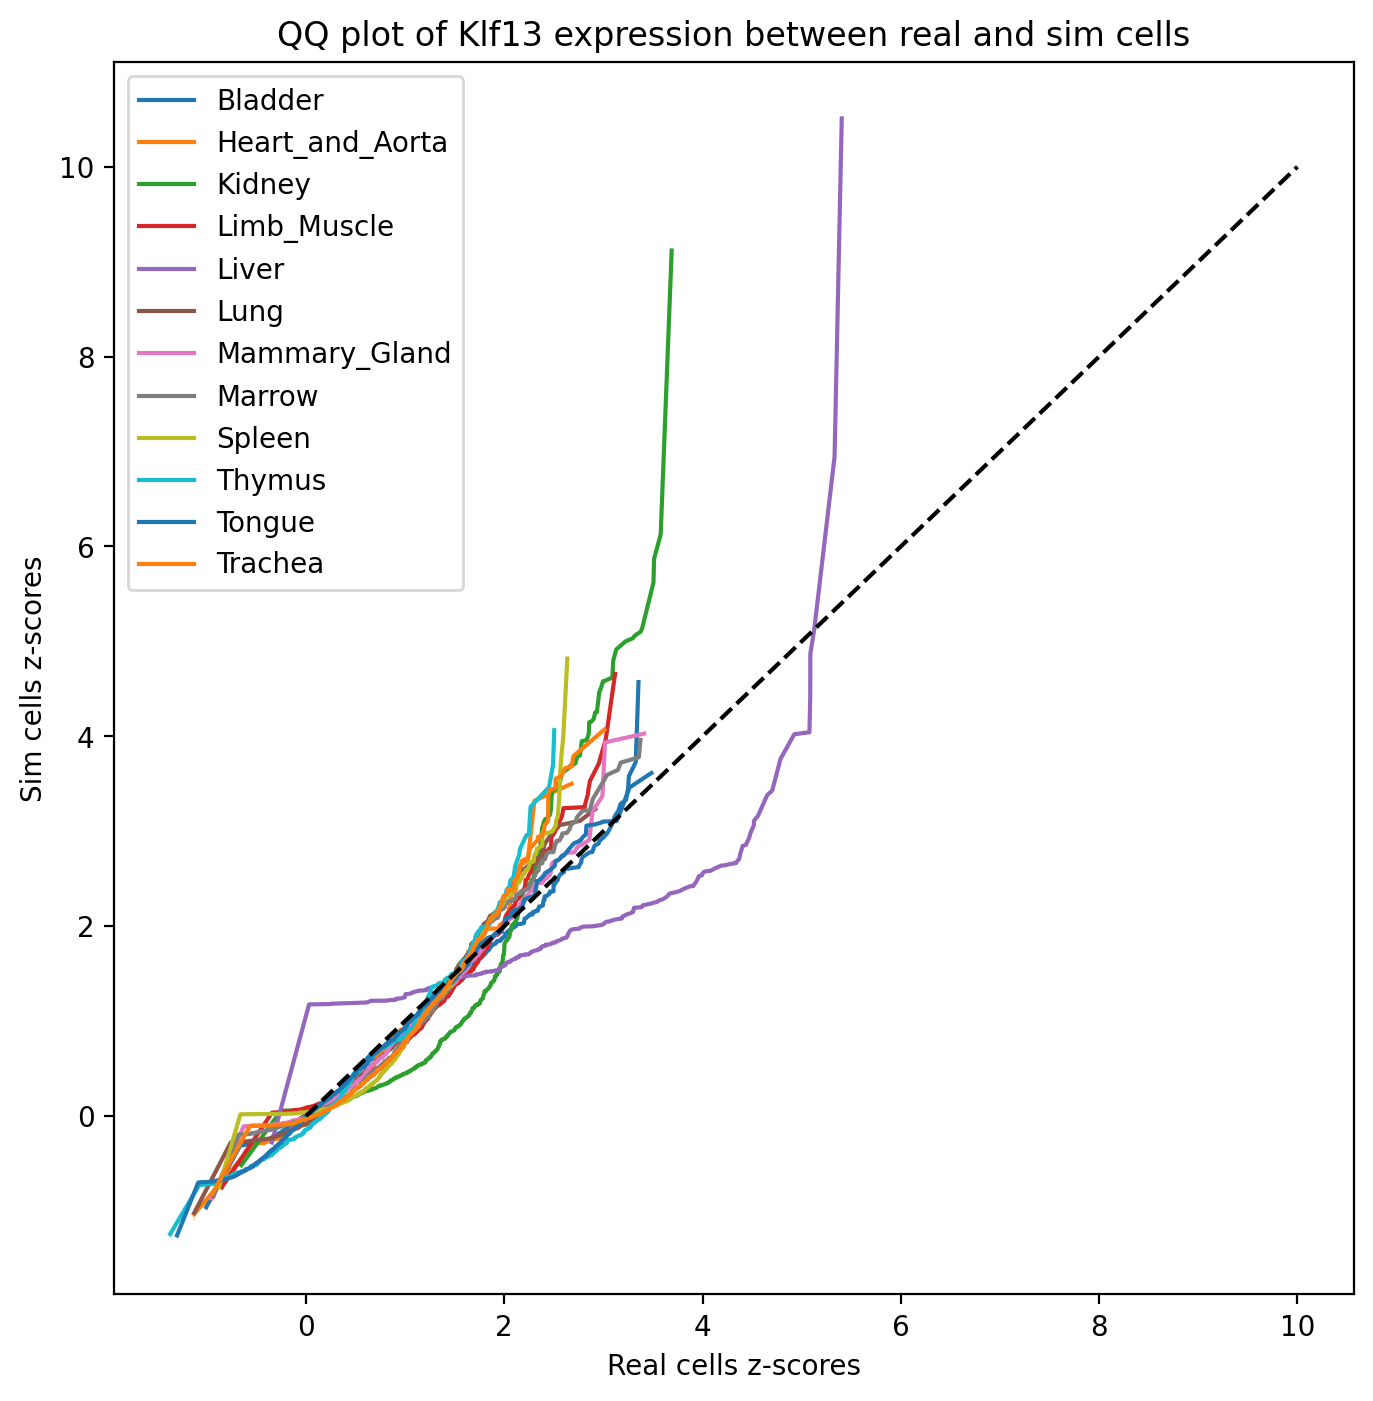

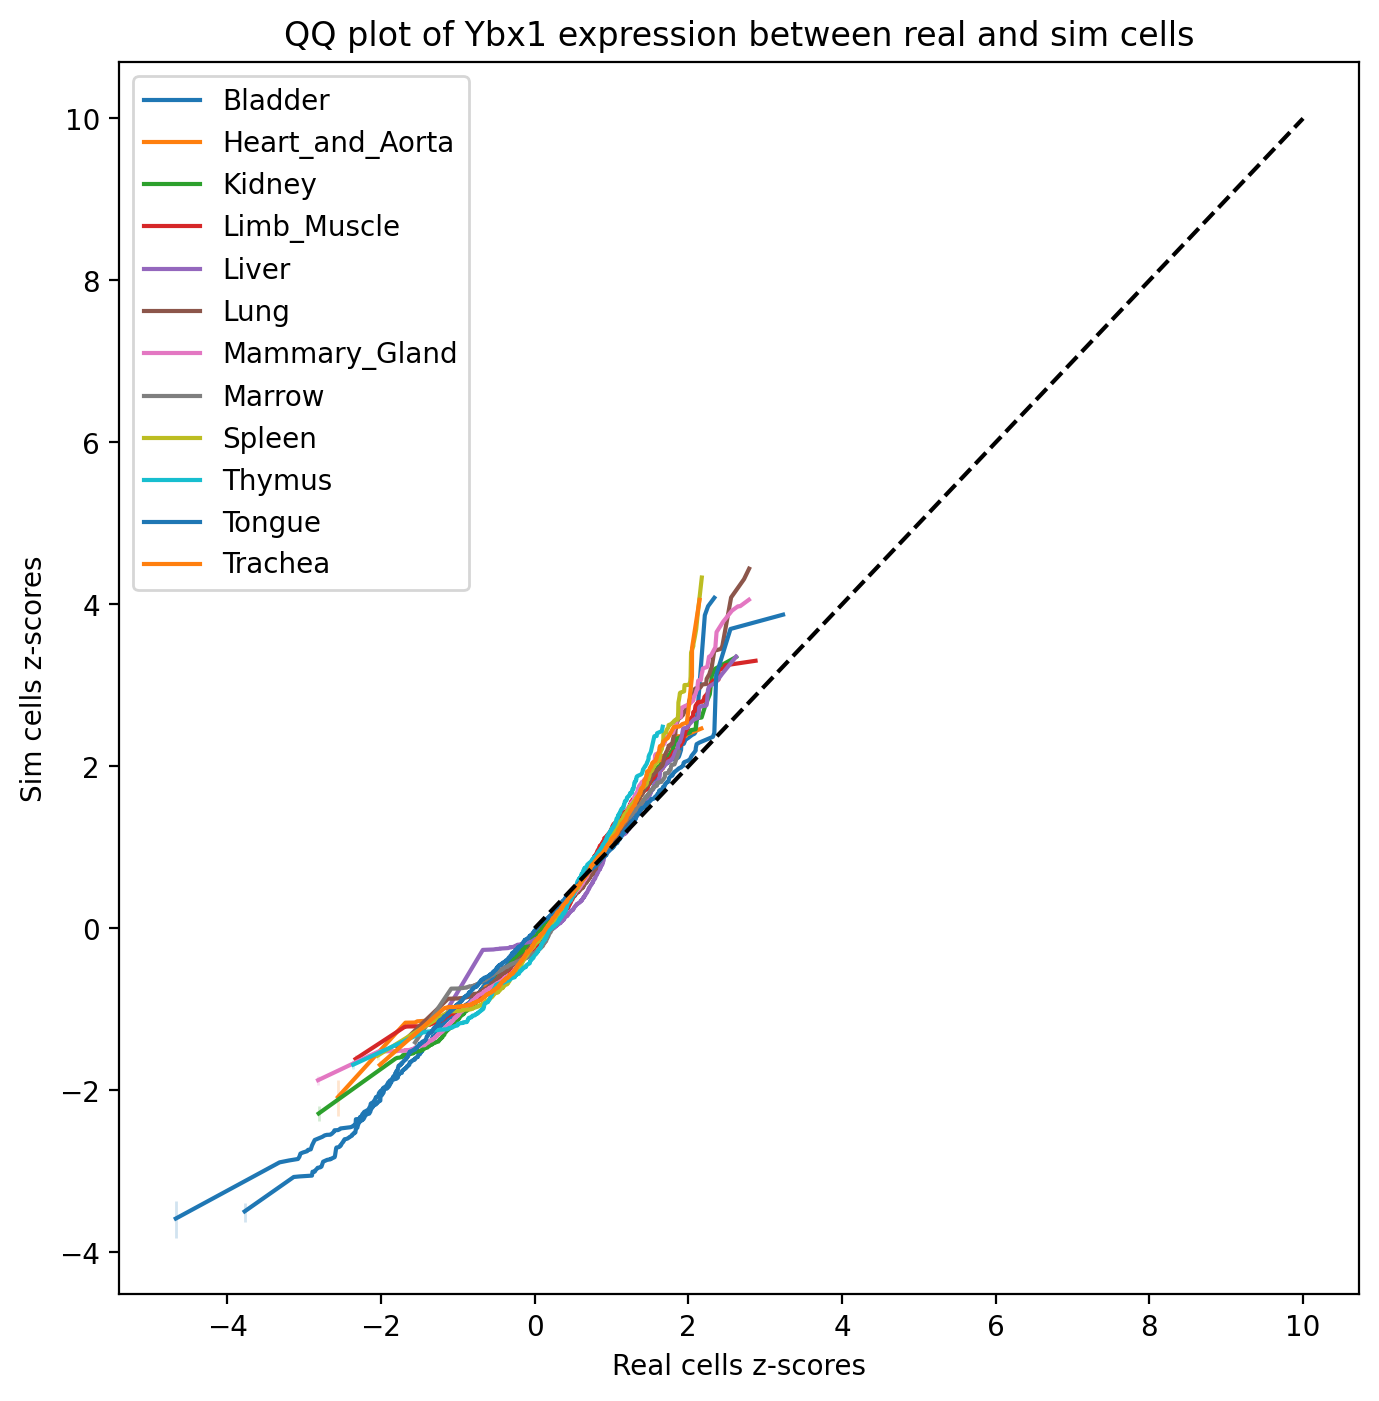

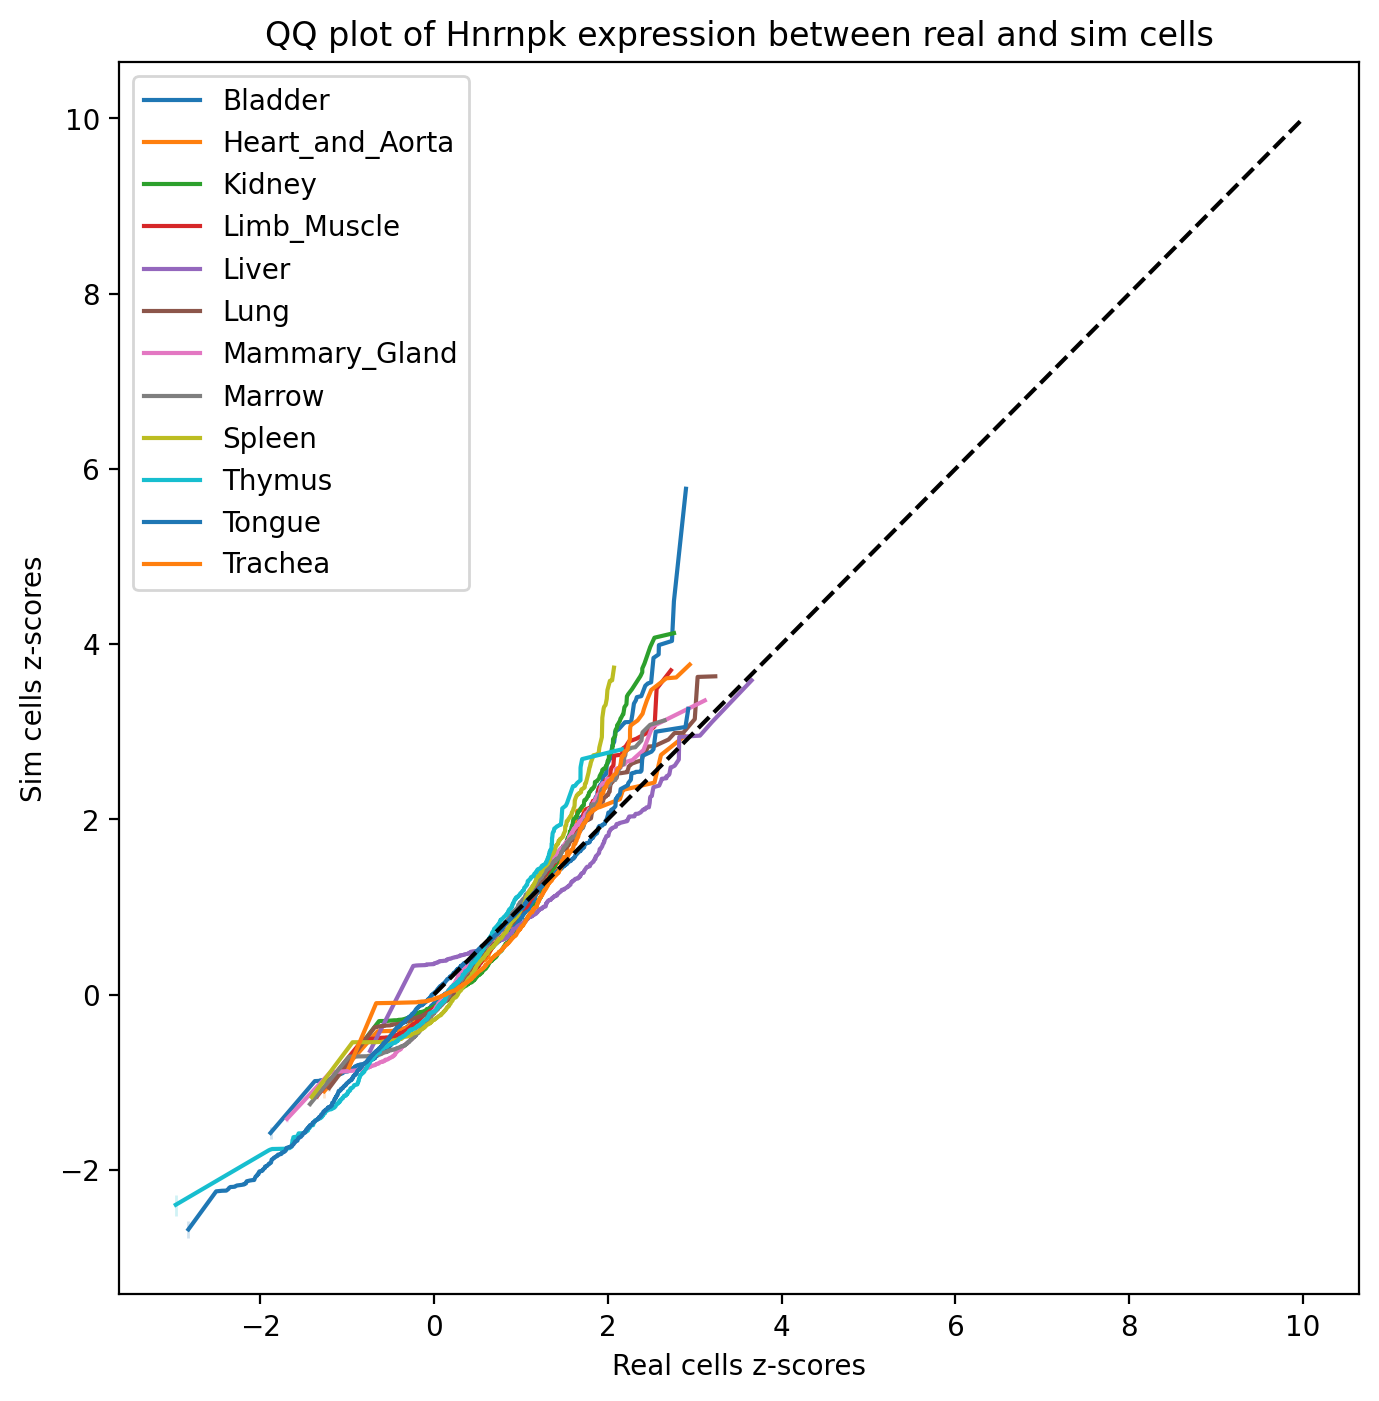

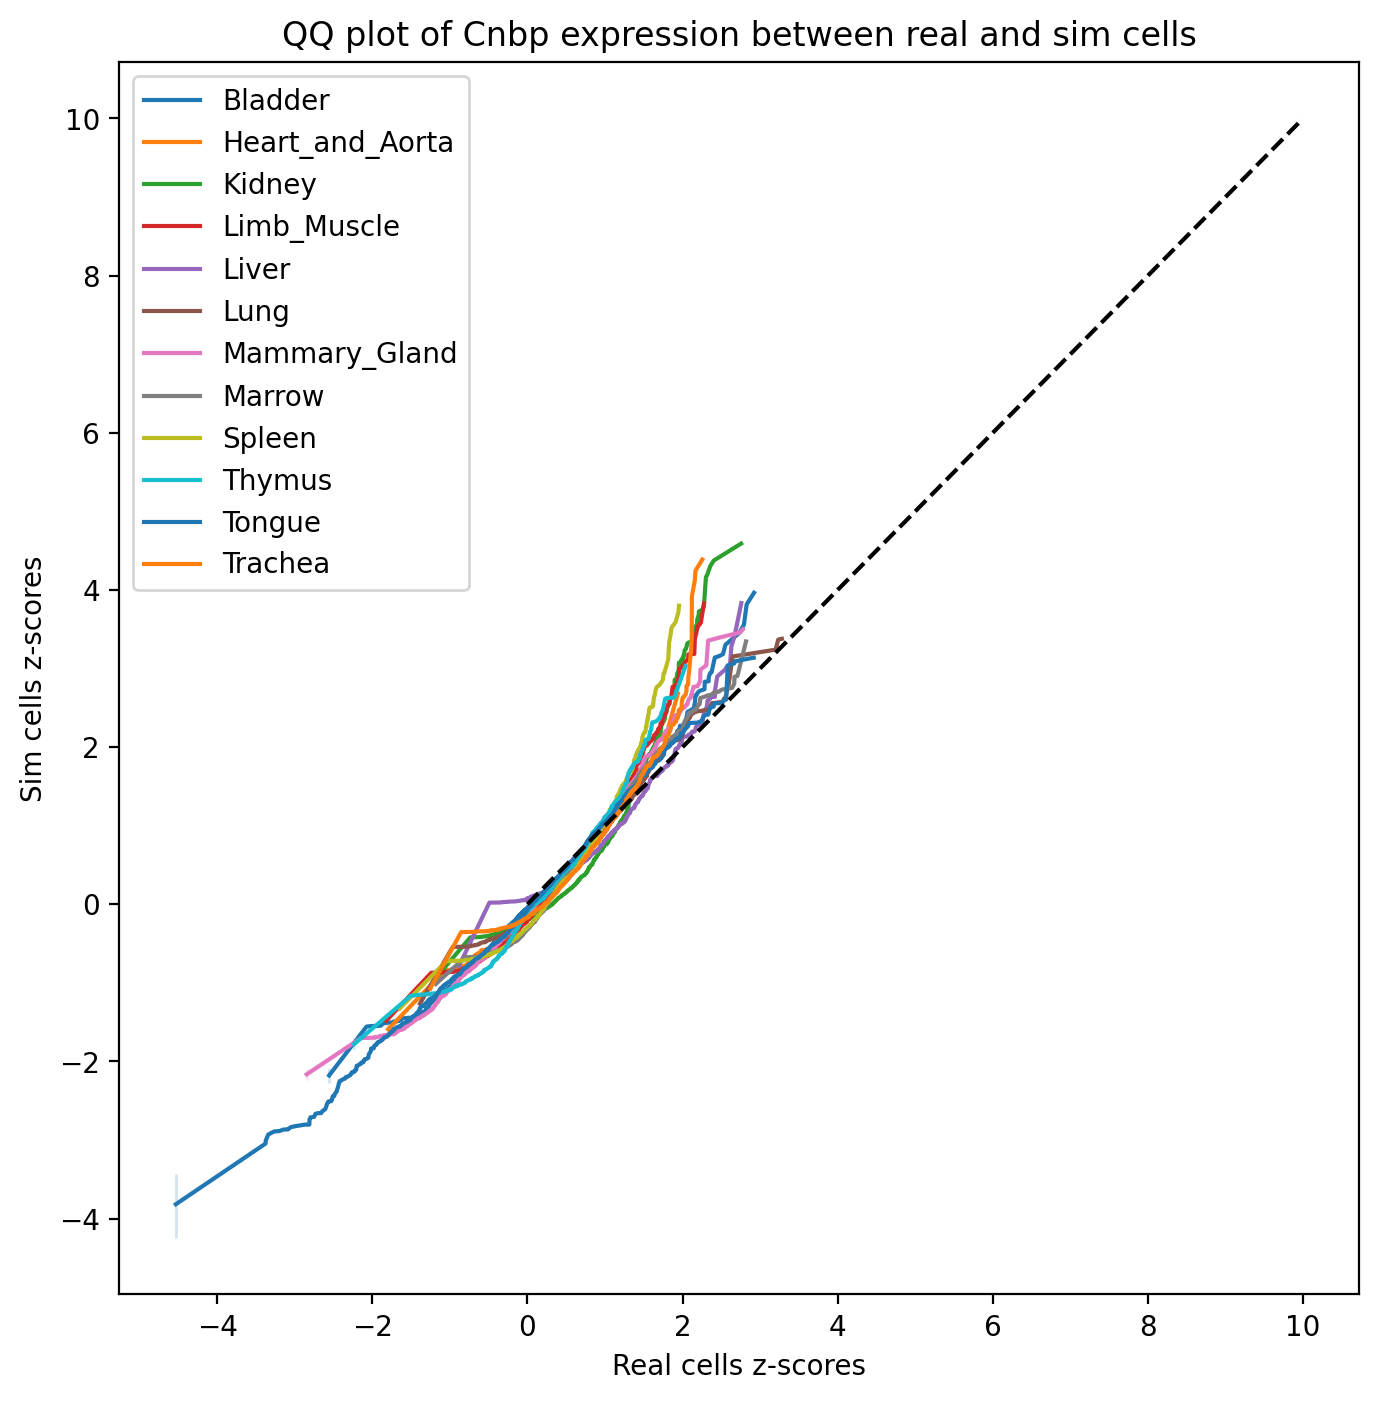

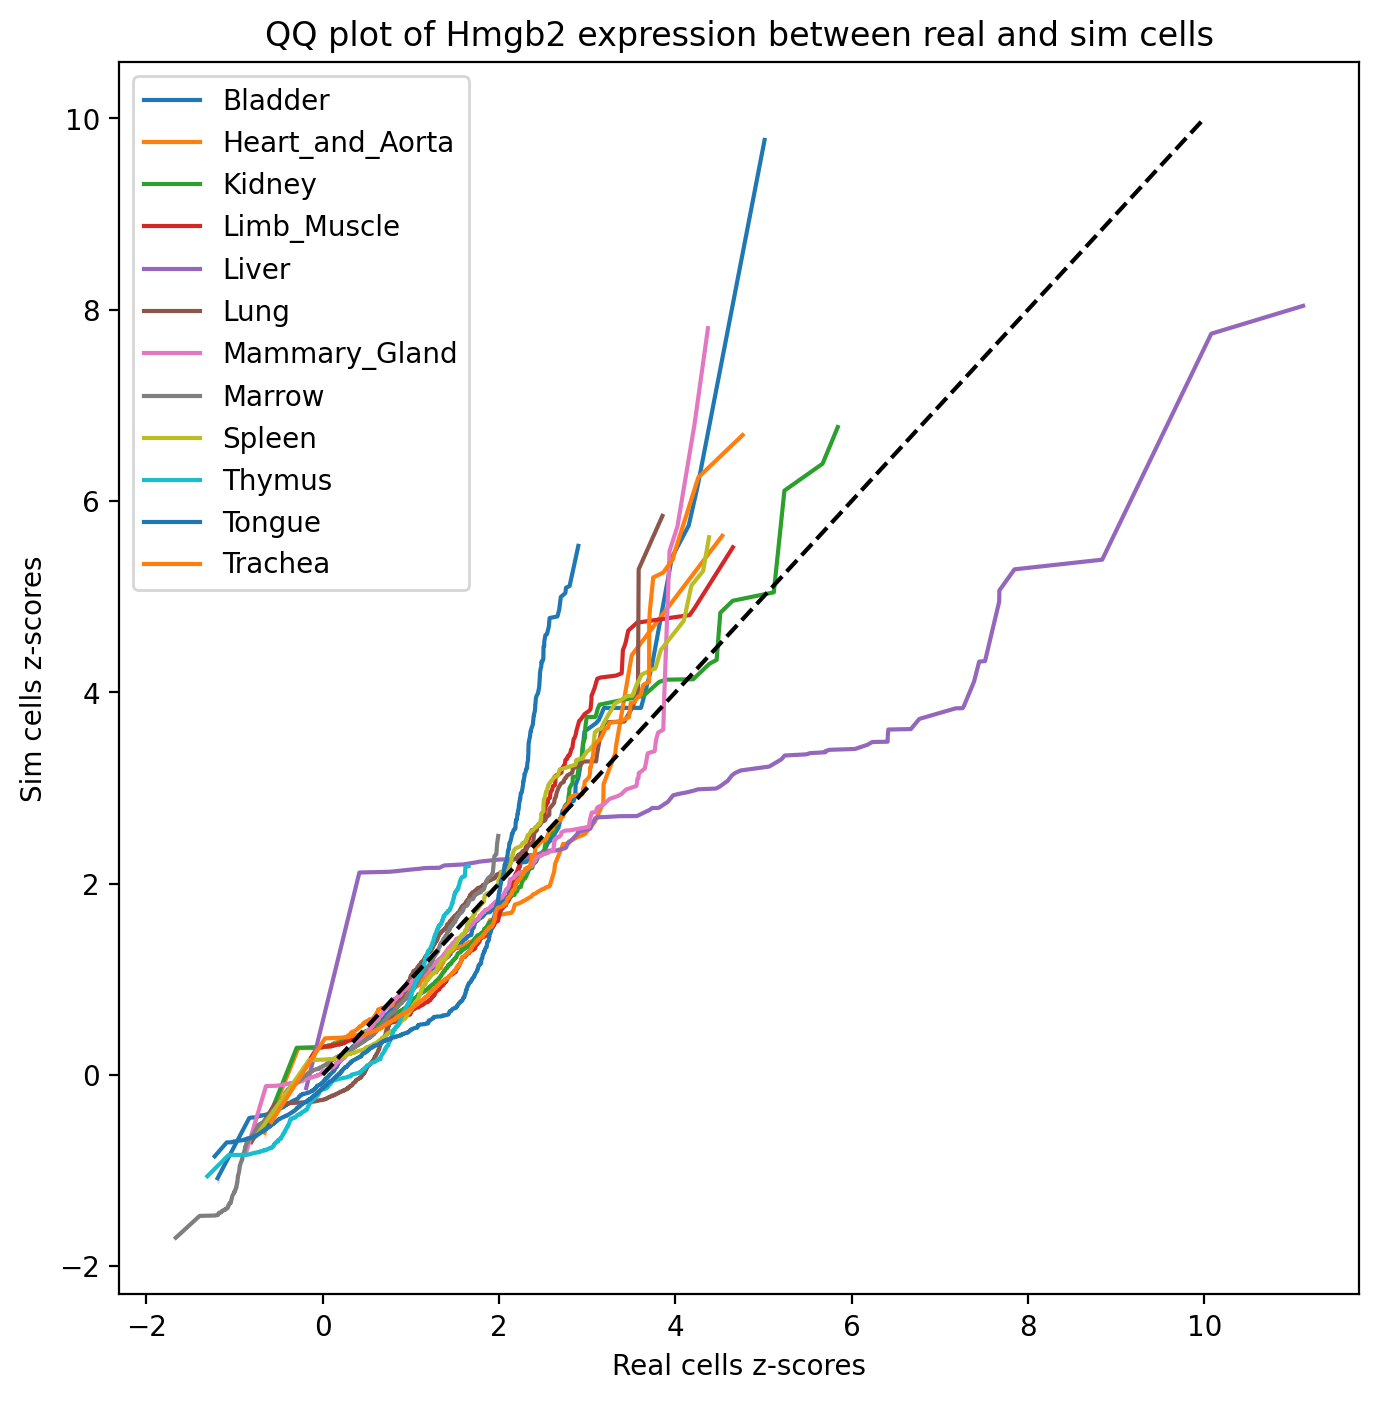

In [ ]:
import scipy.stats as stats  
  
key_tf = ['Klf13','Ybx1','Hnrnpk','Cnbp','Hmgb2']

for i in range(len(key_tf)):
    # 找到特定基因的索引  
    gene_of_interest = key_tf[i]  # 替换为你感兴趣的基因名称  
    gene_index = real_adata.var_names.tolist().index(gene_of_interest)  

    plt.figure(figsize=(8, 8))

    for type in np.unique(sim_adata.obs['celltype']):
        # 提取特定基因在 real 和 sim 类细胞中的表达  
        a = real_adata[real_adata.obs['celltype'] == type]
        b = sim_adata[sim_adata.obs['celltype'] == type]
        size = min(a.X.toarray().shape[0],b.X.toarray().shape[0])
        real_gene_expression = a[:size, gene_index].X.toarray().squeeze(-1)  
        sim_gene_expression = b[:size, gene_index].X.toarray().squeeze(-1)  
        
        # 计算特定基因在 real 和 sim 类细胞中表达的 z-score  
        real_gene_z_scores = stats.zscore(real_gene_expression)  
        sim_gene_z_scores = stats.zscore(sim_gene_expression)  
        
        # 对 z-scores 进行排序  
        real_gene_z_scores_sorted = np.sort(real_gene_z_scores)  
        sim_gene_z_scores_sorted = np.sort(sim_gene_z_scores)  
        
        # 绘制 QQ plot    
        sns.lineplot(x=real_gene_z_scores_sorted, y=sim_gene_z_scores_sorted, label=type) #,edgecolor="none" 

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.xlabel("Real cells z-scores")  
    plt.ylabel("Sim cells z-scores") 
    plt.legend(loc="upper left") #np.unique(type1),
    plt.title(f"QQ plot of {gene_of_interest} expression between real and sim cells")  
    plt.plot([0,10], [0,10], linestyle="--",color='black')  
    # plt.xlim(0, 9)
    # plt.ylim(0, 9)
    # plt.show()  
    # plt.savefig(f'/data1/lep/Workspace/guided-diffusion/figure_pdf_new/qq_plot/muris_chara_gene{i+1}_QQ.pdf')

